In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# reload data
train = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv")
test = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/test.csv")

# monthly aggregation
monthly = (
    train
    .groupby(["date_block_num", "shop_id", "item_id"], as_index=False)["item_cnt_day"]
    .sum()
    .rename(columns={"item_cnt_day": "item_cnt_month"})
)

# lag feature
monthly_sorted = monthly.sort_values(["shop_id", "item_id", "date_block_num"])
monthly_sorted["item_cnt_month_lag1"] = (
    monthly_sorted
    .groupby(["shop_id", "item_id"])["item_cnt_month"]
    .shift(1)
)

# drop missing lag
data = monthly_sorted.dropna(subset=["item_cnt_month_lag1"]).copy()

# train / validation split
train_data = data[data["date_block_num"] < 33]
val_data   = data[data["date_block_num"] == 33]

X_train = train_data[["item_cnt_month_lag1"]]
y_train = train_data["item_cnt_month"]
X_val   = val_data[["item_cnt_month_lag1"]]
y_val   = val_data["item_cnt_month"]

# fit model and get validation predictions
model = LinearRegression()
model.fit(X_train, y_train)
val_pred = model.predict(X_val)

rmse = mean_squared_error(y_val, val_pred, squared=False)
print("Validation RMSE:", rmse)
print("Train rows:", train_data.shape[0], "Val rows:", val_data.shape[0])


Validation RMSE: 14.13302633756186
Train rows: 1160589 Val rows: 24411


In [55]:
import pandas as pd

train = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv")
test = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()



monthly = (
    train
    .groupby(["date_block_num", "shop_id", "item_id"], as_index=False)["item_cnt_day"]
    .sum()
    .rename(columns={"item_cnt_day": "item_cnt_month"})
)

print(monthly.shape)
monthly.head()


Train shape: (2935849, 6)
Test shape: (214200, 3)
(1609124, 4)


,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [56]:
train_data = data[data["date_block_num"] < 33]
val_data = data[data["date_block_num"] == 33]

print(train_data["date_block_num"].unique()[:5], "...")
print("Train rows:", train_data.shape[0])
print("Val rows:", val_data.shape[0])
val_data.head()


[ 1 17  5 15 16] ...
Train rows: 1160589
Val rows: 24411


,date_block_num,shop_id,item_id,item_cnt_month,item_cnt_month_lag1
1577593,33,2,31,1.0,1.0
1577594,33,2,486,3.0,1.0
1577595,33,2,787,1.0,1.0
1577599,33,2,1075,1.0,1.0
1577601,33,2,1377,1.0,1.0


In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# 1) Define features (X) and target (y)
X_train = train_data[["item_cnt_month_lag1"]]
y_train = train_data["item_cnt_month"]

X_val = val_data[["item_cnt_month_lag1"]]
y_val = val_data["item_cnt_month"]

# 2) Fit a simple linear regression model
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# 3) Predict on validation and evaluate
val_pred = baseline_model.predict(X_val)

rmse = mean_squared_error(y_val, val_pred, squared=False)
print("Validation RMSE:", rmse)

# Show first few predictions vs actuals
comparison = val_data[["shop_id", "item_id", "item_cnt_month"]].copy()
comparison["predicted_cnt_month"] = val_pred
comparison.head()


Validation RMSE: 14.13302633756186


,shop_id,item_id,item_cnt_month,predicted_cnt_month
1577593,2,31,1.0,1.121599
1577594,2,486,3.0,1.121599
1577595,2,787,1.0,1.121599
1577599,2,1075,1.0,1.121599
1577601,2,1377,1.0,1.121599


In [58]:
data_enhanced = data.copy()

data_enhanced["prev_month_nonzero"] = (data_enhanced["item_cnt_month_lag1"] > 0).astype(int)

feature_cols = ["item_cnt_month_lag1", "date_block_num", "prev_month_nonzero"]

train_enh = data_enhanced[data_enhanced["date_block_num"] < 33]
val_enh = data_enhanced[data_enhanced["date_block_num"] == 33]

X_train_enh = train_enh[feature_cols]
y_train_enh = train_enh["item_cnt_month"]

X_val_enh = val_enh[feature_cols]
y_val_enh = val_enh["item_cnt_month"]

X_train_enh.head()


,item_cnt_month_lag1,date_block_num,prev_month_nonzero
63226,6.0,1,1
63227,3.0,1,1
63228,1.0,1,1
63233,2.0,1,1
63238,25.0,1,1


In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

rf_model = RandomForestRegressor(
    n_estimators=50,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_enh, y_train_enh)

val_pred_rf = rf_model.predict(X_val_enh)

rmse_rf = mean_squared_error(y_val_enh, val_pred_rf, squared=False)
print("Baseline Linear Regression RMSE (from before): 14.1330 (approx)")
print("RandomForest RMSE:", rmse_rf)

comparison_rf = val_enh[["shop_id", "item_id", "item_cnt_month"]].copy()
comparison_rf["predicted_cnt_month_rf"] = val_pred_rf
comparison_rf.head()


Baseline Linear Regression RMSE (from before): 14.1330 (approx)
RandomForest RMSE: 15.207545002793266


,shop_id,item_id,item_cnt_month,predicted_cnt_month_rf
1577593,2,31,1.0,1.330377
1577594,2,486,3.0,1.330377
1577595,2,787,1.0,1.330377
1577599,2,1075,1.0,1.330377
1577601,2,1377,1.0,1.330377


In [60]:
from sklearn.linear_model import LinearRegression

# Use all rows that have a valid lag (that's already what `data` is)
X_all = data[["item_cnt_month_lag1"]]
y_all = data["item_cnt_month"]

final_model = LinearRegression()
final_model.fit(X_all, y_all)

print("Trained final linear model on", X_all.shape[0], "rows.")


Trained final linear model on 1185000 rows.


In [61]:
from sklearn.linear_model import LinearRegression

# Use all rows that have a valid lag (that's already what `data` is)
X_all = data[["item_cnt_month_lag1"]]
y_all = data["item_cnt_month"]

final_model = LinearRegression()
final_model.fit(X_all, y_all)

print("Trained final linear model on", X_all.shape[0], "rows.")


Trained final linear model on 1185000 rows.


In [62]:
# assumes you already have `train` loaded from train.csv
monthly = (
    train
    .groupby(["date_block_num", "shop_id", "item_id"], as_index=False)["item_cnt_day"]
    .sum()
    .rename(columns={"item_cnt_day": "item_cnt_month"})
)

print(monthly.shape)
monthly.head()


(1609124, 4)


,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [63]:
import pandas as pd

train = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv")
test = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()


Train shape: (2935849, 6)
Test shape: (214200, 3)


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [64]:
# 1) Aggregate to monthly level
monthly = (
    train
    .groupby(["date_block_num", "shop_id", "item_id"], as_index=False)["item_cnt_day"]
    .sum()
    .rename(columns={"item_cnt_day": "item_cnt_month"})
)

print("Monthly shape:", monthly.shape)
monthly.head()


Monthly shape: (1609124, 4)


,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [65]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="invalid value encountered in greater",
    category=RuntimeWarning
)

# 2) Sort and add lag-1 feature
monthly_sorted = monthly.sort_values(["shop_id", "item_id", "date_block_num"])

monthly_sorted["item_cnt_month_lag1"] = (
    monthly_sorted
    .groupby(["shop_id", "item_id"])["item_cnt_month"]
    .shift(1)
)

print(monthly_sorted.head().to_string())


       date_block_num  shop_id  item_id  item_cnt_month  item_cnt_month_lag1
63224               1        0       30            31.0                  NaN
63225               1        0       31            11.0                  NaN
0                   0        0       32             6.0                  NaN
63226               1        0       32            10.0                  6.0
1                   0        0       33             3.0                  NaN


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [66]:
# 3) Drop rows without lag
data = monthly_sorted.dropna(subset=["item_cnt_month_lag1"]).copy()
print("Data shape:", data.shape)
data.head()


Data shape: (1185000, 5)


,date_block_num,shop_id,item_id,item_cnt_month,item_cnt_month_lag1
63226,1,0,32,10.0,6.0
63227,1,0,33,3.0,3.0
63228,1,0,35,14.0,1.0
63233,1,0,51,3.0,2.0
63238,1,0,98,5.0,25.0


In [67]:
from sklearn.linear_model import LinearRegression

X_all = data[["item_cnt_month_lag1"]]
y_all = data["item_cnt_month"]

final_model = LinearRegression()
final_model.fit(X_all, y_all)

print("Trained final linear model on", X_all.shape[0], "rows.")


Trained final linear model on 1185000 rows.


In [68]:
# Get monthly data for October 2015 (date_block_num == 33)
october = monthly[monthly["date_block_num"] == 33][
    ["shop_id", "item_id", "item_cnt_month"]
].copy()

october = october.rename(columns={"item_cnt_month": "item_cnt_month_lag1"})
print("October rows:", october.shape[0])
october.head()


October rows: 31531


,shop_id,item_id,item_cnt_month_lag1
1577593,2,31,1.0
1577594,2,486,3.0
1577595,2,787,1.0
1577596,2,794,1.0
1577597,2,968,1.0


In [69]:
# Start from test.csv pairs
test_with_lag = test.merge(
    october,
    on=["shop_id", "item_id"],
    how="left"
)

# Items that never sold in October get NaN; replace with 0
test_with_lag["item_cnt_month_lag1"] = test_with_lag["item_cnt_month_lag1"].fillna(0)

print(test_with_lag.shape)
test_with_lag.head()


(214200, 4)


,ID,shop_id,item_id,item_cnt_month_lag1
0,0,5,5037,0.0
1,1,5,5320,0.0
2,2,5,5233,1.0
3,3,5,5232,0.0
4,4,5,5268,0.0


In [70]:
X_test = test_with_lag[["item_cnt_month_lag1"]]

test_with_lag["item_cnt_month_pred"] = final_model.predict(X_test)

# Kaggle expects predictions between 0 and 20
test_with_lag["item_cnt_month_pred"] = test_with_lag["item_cnt_month_pred"].clip(0, 20)

test_with_lag[["ID", "item_cnt_month_pred"]].head()


,ID,item_cnt_month_pred
0,0,0.407494
1,1,0.407494
2,2,1.120122
3,3,0.407494
4,4,0.407494


In [71]:
submission = test_with_lag[["ID", "item_cnt_month_pred"]].rename(
    columns={"item_cnt_month_pred": "item_cnt_month"}
)

# THIS is what actually creates the file Kaggle looks for:
submission.to_csv("submission.csv", index=False)

# Optional preview (keeps what you already see)
submission.head()


,ID,item_cnt_month
0,0,0.407494
1,1,0.407494
2,2,1.120122
3,3,0.407494
4,4,0.407494


In [72]:
train_data = monthly_sorted[monthly_sorted["date_block_num"] < 33]
val_data = monthly_sorted[monthly_sorted["date_block_num"] == 33]


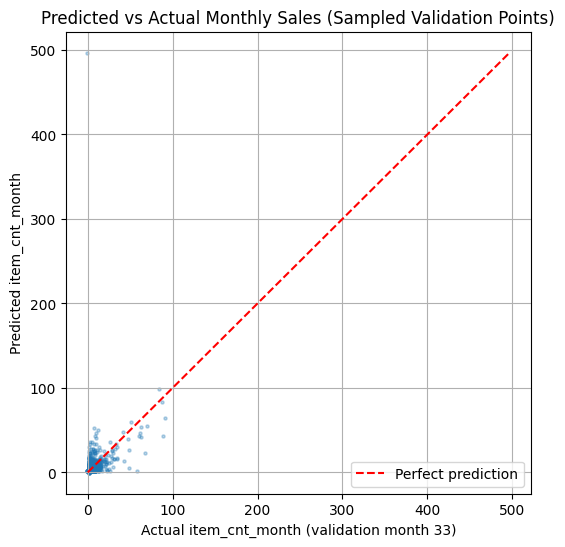

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Turn to arrays/Series if needed
y_val_array = y_val.values
val_pred_array = val_pred

# Choose sample size (e.g., 10,000 points)
sample_size = 10000
n = len(y_val_array)
idx = np.random.choice(n, size=min(sample_size, n), replace=False)

y_sample = y_val_array[idx]
pred_sample = val_pred_array[idx]

plt.figure(figsize=(6, 6))
plt.scatter(y_sample, pred_sample, alpha=0.3, s=5)

max_val = max(y_sample.max(), pred_sample.max())
plt.plot([0, max_val], [0, max_val], color="red", linestyle="--", label="Perfect prediction")

plt.xlabel("Actual item_cnt_month (validation month 33)")
plt.ylabel("Predicted item_cnt_month")
plt.title("Predicted vs Actual Monthly Sales (Sampled Validation Points)")
plt.legend()
plt.grid(True)
plt.show()


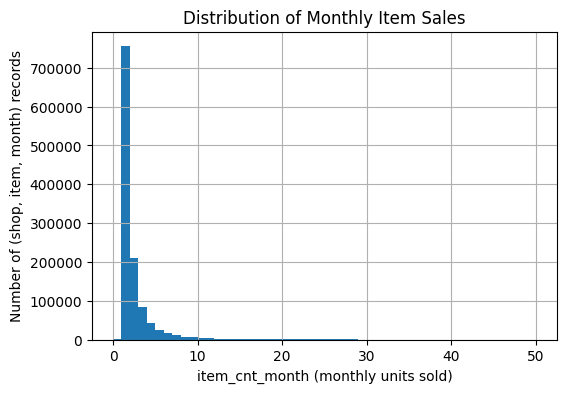

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.hist(data["item_cnt_month"], bins=50, range=(0, 50))
plt.xlabel("item_cnt_month (monthly units sold)")
plt.ylabel("Number of (shop, item, month) records")
plt.title("Distribution of Monthly Item Sales")
plt.grid(True)
plt.show()
